In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools
import igraph

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_graph, evolution_regression, evolution_linlog_regressions, 
                     savefig)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

In [2]:
# Use a subset of dates to speed up the notebook. 
# THIS LINE SHOULD BE COMMENTED OUT IN PRODUCTION!
DATE_RANGE = pandas.date_range(DATE_RANGE[0], DATE_RANGE[-1], freq='3MS')

FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (FIG_SIZE[0] * 1.5, FIG_SIZE[1])
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}
sub = lambda c, e: [c[x] for x in e]

In [3]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cargo: .....................
cpan: .....................
cran: .....................
npm: .....................
nuget: .....................
packagist: .....................
rubygems: .....................


## Graph size

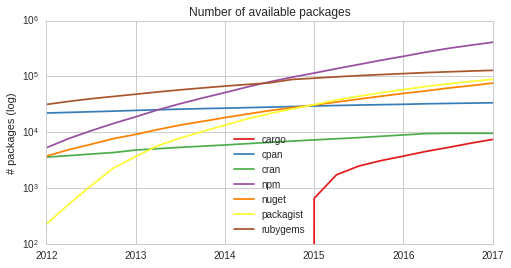

In [4]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = graph.vcount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
)

savefig(figure, 'graph_number_of_packages')

In [5]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.744245,0.998288,0.992523,0.874977,0.942953,0.926931,0.99481
lin-log,0.758834,0.991224,0.983051,0.982534,0.98118,0.896786,0.971747
log-lin,0.211634,0.563017,0.519356,0.311065,0.388053,0.352047,0.518622
log-log,0.268202,0.600444,0.608839,0.638448,0.645092,0.767113,0.640189


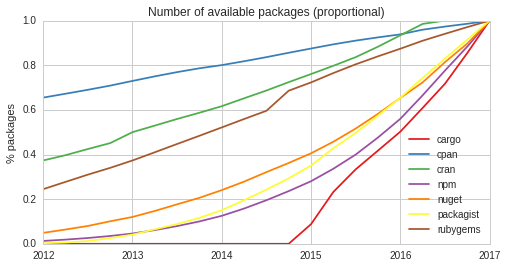

In [6]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = graph.vcount() / graphs[ecosystem][DATE_RANGE[-1]].vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='% packages',
    title='Number of available packages (proportional)',
)

savefig(figure, 'graph_proportion_of_packages')

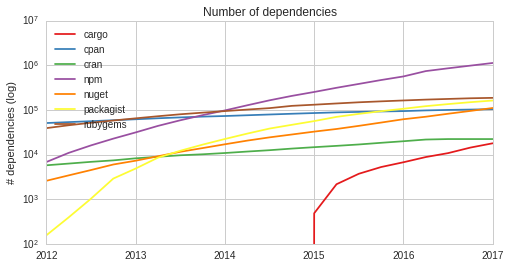

In [7]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
)

savefig(figure, 'graph_number_of_dependencies')

In [8]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.668884,0.997796,0.978078,0.830562,0.88036,0.923883,0.996545
lin-log,0.766994,0.98252,0.990668,0.983303,0.988176,0.869146,0.965941
log-lin,0.179072,0.558401,0.461472,0.276385,0.322834,0.345281,0.521476
log-log,0.268895,0.620473,0.584746,0.64057,0.624897,0.782154,0.658981


## Graph density

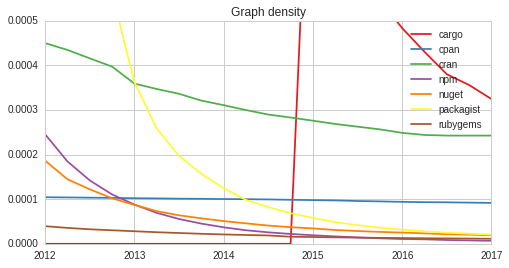

In [9]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        vs = graph.vcount()
        es = graph.ecount()
        df.loc[date, ecosystem] = (es) / (vs * (vs - 1)) if vs > 0 else 0
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
    
ax.set(
    xlabel='', 
    ylabel='',
    title='Graph density',
    ylim=(0, 0.0005),
)

savefig(figure, 'graph_density')

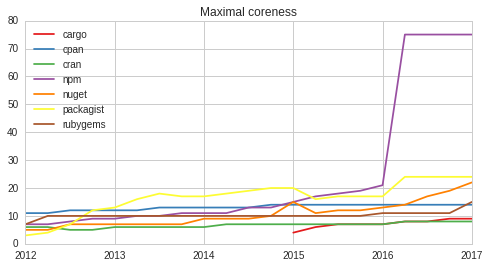

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        coreness = graph.coreness()
        df.loc[date, ecosystem] = pandas.np.max(coreness)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Maximal coreness',
)

savefig(figure, 'graph_maximal_coreness')

## Distribution of dependencies

In [11]:
data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for node in graph.vs:
        if node['in'] + node['out'] == 0:
            continue
            
        data.append((
            ecosystem, 
            node['in'],
            node['out'],
            node['tr-in'],
            node['tr-out']
        ))
        
data = (
    pandas.DataFrame.from_records(
        data, 
        columns=['ecosystem', 'in', 'out', 'tr-in', 'tr-out']
    )
    .pipe(
        pandas.melt,
        id_vars='ecosystem', 
        value_vars=['in', 'out', 'tr-in', 'tr-out'], 
        var_name='kind'
    )
)

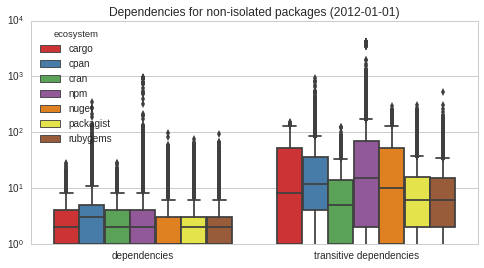

In [14]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

keep_kind = ['out', 'tr-out']

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data[data['kind'].isin(keep_kind)],
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS
)

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Dependencies for non-isolated packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['dependencies', 'transitive dependencies'])

savefig(figure, 'graph_distribution_dependencies_non_isolated')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


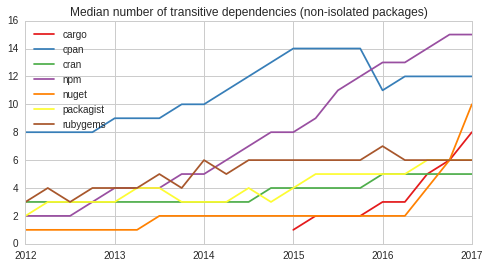

In [15]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = pandas.np.median(
            [v['tr-out'] for v in graph.vs if v['in'] + v['out'] > 0]
        )
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies (non-isolated packages)',
)

savefig(figure, 'graph_median_transitive_dependencies')

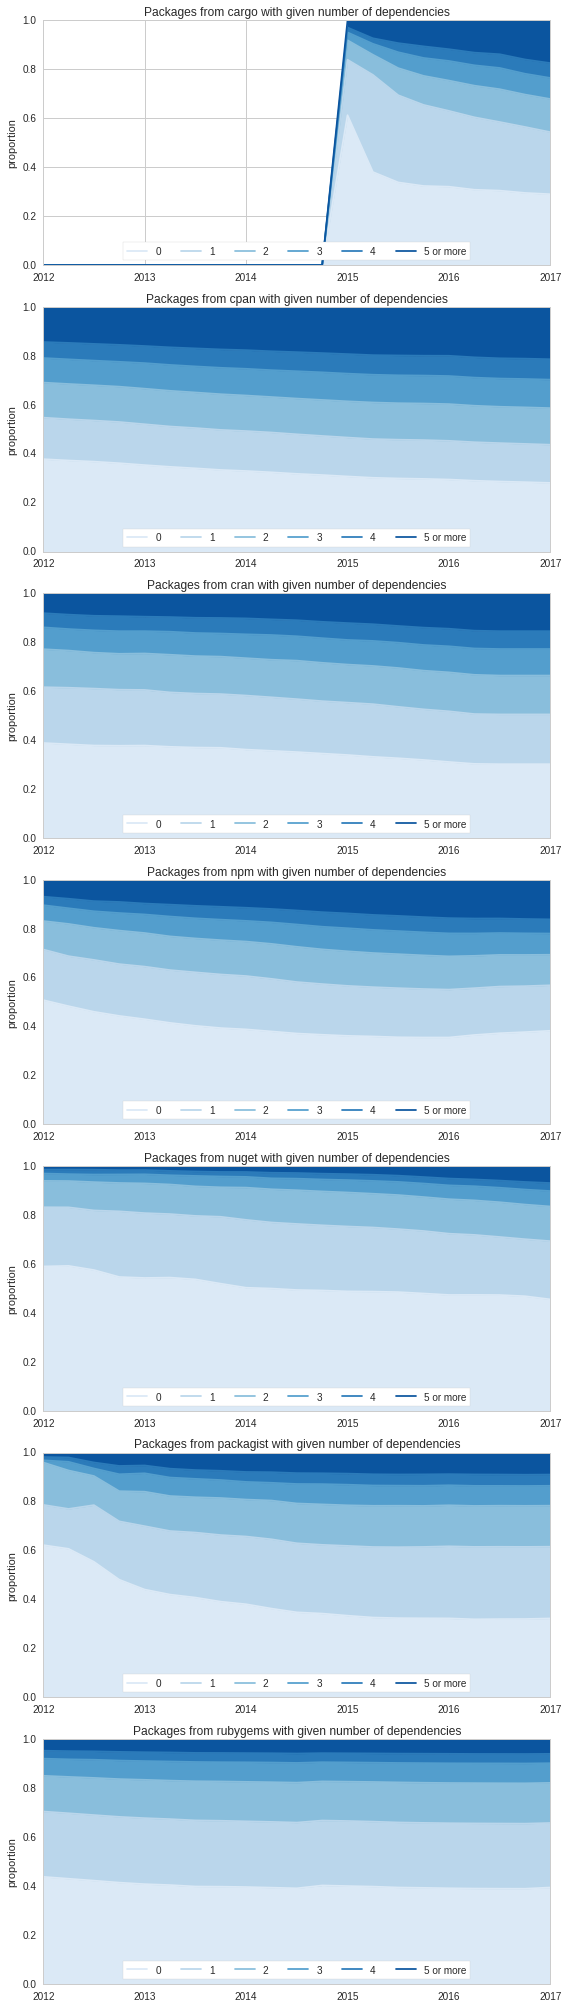

In [16]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))
        
bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5 or more']
                       
for i, (ecosystem, dates) in enumerate(graphs.items()):
    ax = axes[i]
    df = pandas.DataFrame(index=DATE_RANGE, columns=labels)
    
    for date, graph in dates.items():
        counter = collections.Counter(
            pandas.cut(
                graph.vs['out'],
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
        for label in labels: 
            df.loc[date, label] = counter[label] / graph.vcount() if graph.vcount() > 0 else 0
    
    df.plot.area(ax=ax, color=seaborn.color_palette('Blues'))
    
    ax.set(
        xlabel='',
        ylabel='proportion',
        title='Packages from {} with given number of dependencies'.format(ecosystem),
        ylim=(0, 1)
    )
    
    ax.legend(
        ncol=len(labels),
        loc='lower center', 
        frameon=True,
    )

matplotlib.pyplot.tight_layout()

savefig(figure, 'graph_proportion_packages_with_number_of_dependencies')

## Isolated packages

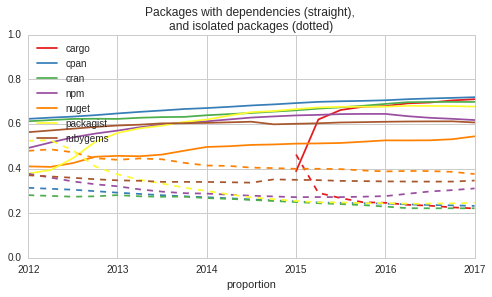

In [20]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2 = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        with_deps = len(list(filter(lambda v: v['out'] > 0, graph.vs)))
        connected = len(list(filter(lambda v: v['in'] + v['out'] > 0, graph.vs)))
        
        try:
            df.loc[date, ecosystem] = with_deps / graph.vcount()
            df2.loc[date, ecosystem] = 1 - (connected / graph.vcount())
        except ZeroDivisionError:
            pass
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))
df2.plot(ax=ax, style='--', legend=False, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='proportion', 
    ylabel='',
    title='Packages with dependencies (straight), \nand isolated packages (dotted)',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_packages_with_dependencies_and_isolated')

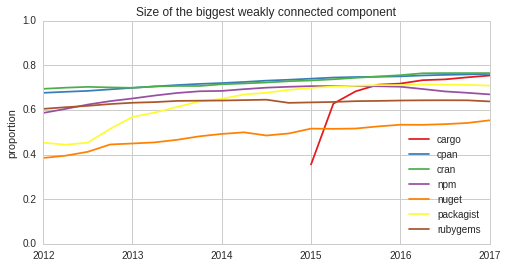

In [25]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        components = graph.components(mode=igraph.WEAK)
        df.loc[date, ecosystem] = components.giant().vcount() / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Size of the biggest weakly connected component',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_size_of_biggest_wcc')

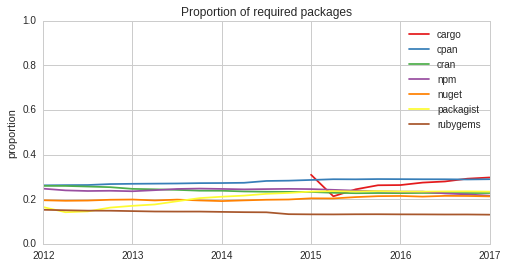

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        required = len([v for v in graph.vs if v['in'] > 0])
        df.loc[date, ecosystem] = required / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of required packages',
    ylim=(0, 1),
)

savefig(figure, 'graph_proportion_required_packages')

## Top-level packages
Top-level packages are packages that are not required but have at least one dependency.

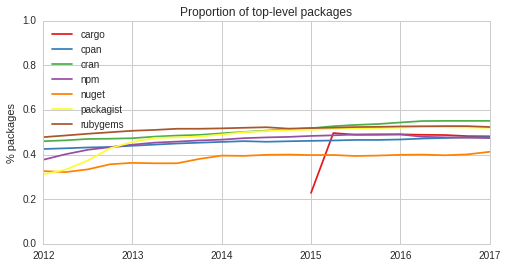

In [27]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = len(graph.vs.select(in_eq=0, out_gt=0)) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='% packages', 
    title='Proportion of top-level packages',
    ylim=(0, 1)
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_proportion_top_level')

In [28]:
import statsmodels.api as sm
def evolution_linlog_regressions(df, return_raw=False):
    """
    Return the results of multiple regressions (lin/log).
    """
    data = pandas.DataFrame(columns=df.columns)
    
    data.loc['lin-lin', :] = evolution_regression(df, return_raw=return_raw)
    data.loc['lin-log', :] = evolution_regression(df, ylog=True, return_raw=return_raw)
    data.loc['log-lin', :] = evolution_regression(df, xlog=True, return_raw=return_raw)
    data.loc['log-log', :] = evolution_regression(df, xlog=True, ylog=True, return_raw=return_raw)
    
    return data

def evolution_regression(df, xlog=False, ylog=False, return_raw=False):
    """
    Return R² value for df.index] ~ a.df[x] + b for all column x in given dataframe.
    
    If 'return_raw' is True, return the resulting OLS object instead of its R².
    The results are returned through a dict which associates to each column  the result of the regression.
    """
    results = collections.OrderedDict()
    
    time = pandas.Series(df.index)
    X = 1 + (time - time.min()).dt.days
    X = pandas.np.log10(X) if xlog else X
    X = sm.add_constant(X, prepend=False)
    
    for column in df.columns:
        if not ylog:
            y = df[column]
        else:
            y = pandas.np.log10(df[column].apply(lambda v: max(v, 10e-5)))
        y = y.reset_index(drop=True)
        
        result = sm.OLS(y, X).fit()
        
        results[column] = result if return_raw else result.rsquared
        
    return results

In [29]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,NaN,0.951784,0.987007,0.666419,0.772095,0.696673,0.763932
lin-log,NaN,0.946058,0.987283,0.650437,0.759274,0.649181,0.755349
log-lin,NaN,0.640729,0.511881,0.826733,0.655832,0.804724,0.803777
log-log,NaN,0.650174,0.526485,0.848793,0.665676,0.825641,0.810624


In [30]:
df_out = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_trout = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df_ratio = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():    
        if graph.vcount() == 0:
            continue
        vs = graph.vs.select(in_eq=0, out_gt=0)
        out = pandas.Series(vs['out'])
        trout = pandas.Series(vs['tr-out'])
        
        df_out.loc[date, ecosystem] = pandas.np.mean(out)
        df_trout.loc[date, ecosystem] = pandas.np.mean(trout)
        df_ratio.loc[date, ecosystem] = pandas.np.mean(trout / out)

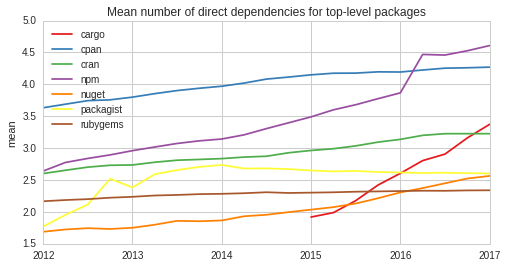

In [31]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_out.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of direct dependencies for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) //2 )

savefig(figure, 'graph_toplevel_mean_direct')

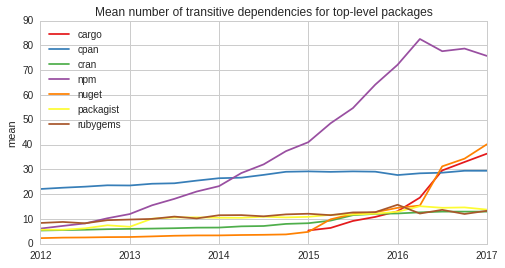

In [32]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_trout.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean number of transitive dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_transitive')

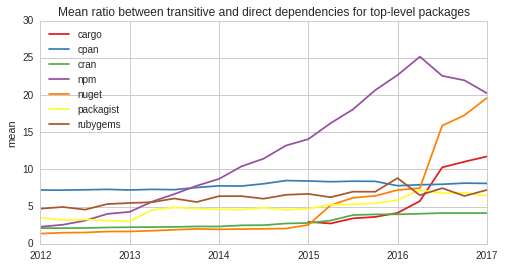

In [33]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df_ratio.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='mean', 
    title='Mean ratio between transitive and direct dependencies for top-level packages',
)

savefig(figure, 'graph_toplevel_mean_ratio')

In [34]:
date = DATE_RANGE[-1]

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    vs = graph.vs.select(in_eq=0, out_gt=0)
    data.extend(zip(
        itertools.repeat(ecosystem), 
        vs['out'],
        vs['tr-out']
    ))
            
df = (
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'out', 'tr-out'])
    .assign(ratio=lambda d: d['tr-out'] / d['out'])
    .pipe(lambda d: pandas.melt(d, id_vars='ecosystem', value_vars=['out', 'tr-out', 'ratio'], var_name='kind'))
)

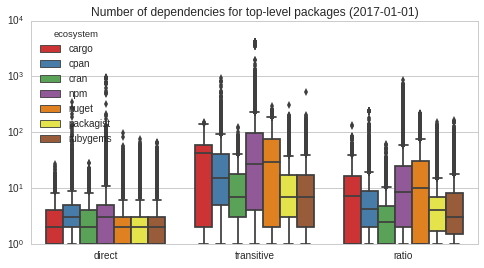

In [35]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=df,
    ax=ax,
    order=['out', 'tr-out', 'ratio'],
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Number of dependencies for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['direct', 'transitive', 'ratio'])
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_distribution_dependencies')

/home/alexandre/.local/share/virtualenvs/ecos-emse/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


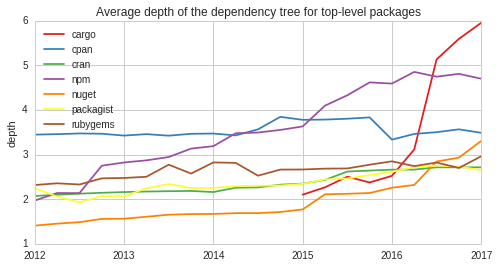

In [36]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        data = []
        for node in graph.vs.select(in_eq=0, out_gt=0):
            m = max((d for v, d, p in graph.bfsiter(node, advanced=True)))
            data.append(m)
        df.loc[date, ecosystem] = pandas.np.mean(data)
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='depth', 
    title='Average depth of the dependency tree for top-level packages',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_mean_depth')

In [37]:
date = DATE_RANGE[-1]

bins = [1, 2, 3, 4, 5, 6, pandas.np.inf]
labels = ['1', '2', '3', '4', '5', '6 or more']

data = []
for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    for node in graph.vs.select(in_eq=0, out_gt=0): 
        depths = []
        for v, d, p in graph.bfsiter(node, advanced=True):
            depths.append(d)
        
        d_max = max(depths)
        d_count = collections.Counter(
            pandas.cut(depths, bins=bins, labels=labels, right=False, include_lowest=True)
        )
        
        data.append([ecosystem, d_max] + [d_count[v] for v in labels])

In [38]:
df = pandas.melt(
    pandas.DataFrame.from_records(data, columns=['ecosystem', 'depth'] + labels),
    id_vars='ecosystem',
    value_vars=['depth'] + labels
)

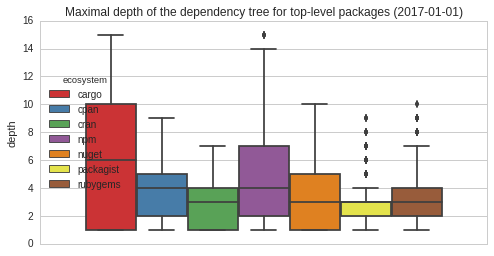

In [39]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.boxplot(
    x='_', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable == "depth"').assign(_=1),
    ax=ax,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='', 
    ylabel='depth',
    title='Maximal depth of the dependency tree for top-level packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels([''])
ax.legend(ncol=len(ECOSYSTEMS) // 4)

savefig(figure, 'graph_toplevel_distribution_depth')

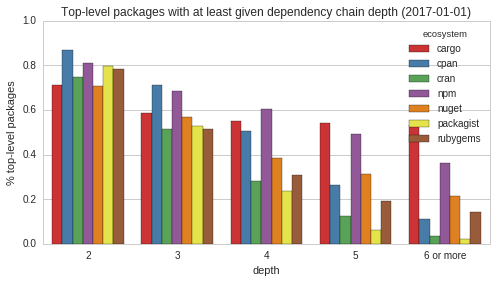

In [40]:
# Proportion of packages with at least one dependency at given depth

df_tmp = (
    df
    .query('variable != "depth" and value > 0')
    .groupby(['ecosystem', 'variable'])
    .count()
    .pipe(lambda d: 
        d.apply(lambda r: r / d.loc[(r.name[0], '1'), 'value'], axis=1)
    )
)


figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

seaborn.barplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df_tmp.reset_index(),
    ax=ax,
    order=labels[1:],
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='depth', 
    ylabel='% top-level packages',
    title='Top-level packages with at least given dependency chain depth ({})'.format(date.strftime('%Y-%m-%d')),
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_toplevel_proportion_at_least_depth')

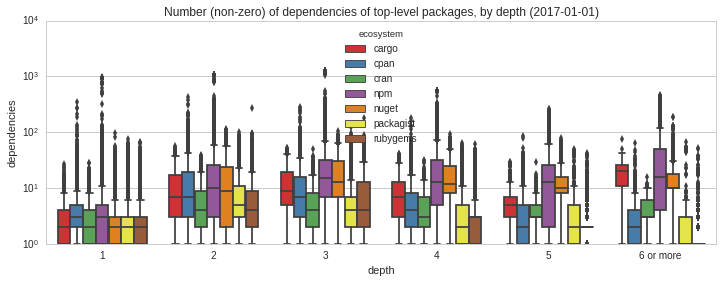

In [41]:
# Number of dependencies by dependency depth

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE_WIDE)

seaborn.boxplot(
    x='variable', 
    y='value', 
    hue='ecosystem',
    data=df.query('variable != "depth" and value > 0'),
    ax=ax,
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
)

ax.set(
    xlabel='depth', 
    ylabel='dependencies',
    yscale='log',
    title='Number (non-zero) of dependencies of top-level packages, by depth ({})'.format(date.strftime('%Y-%m-%d')),
)    
ax.legend(ncol=len(ECOSYSTEMS))

savefig(figure, 'graph_toplevel_distribution_deps_by_depth')

## Relative impact

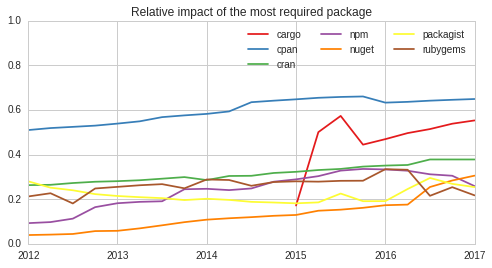

In [45]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = max(graph.vs['tr-in']) / graph.vcount()
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Relative impact of the most required package',
    ylim=(0, 1),
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'graph_most_required_relative_impact')

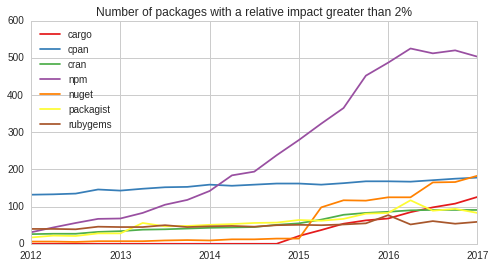

In [46]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 2

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(graph.vs.select(**{'tr-in_ge': p_threshold}))
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
)

savefig(figure, 'graph_relative_impact_{}'.format(threshold))

In [47]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.777791,0.940269,0.938184,0.944408,0.787018,0.874916,0.597978
lin-log,0.758644,0.926191,0.970799,0.967514,0.868514,0.86593,0.681289
log-lin,0.229457,0.624555,0.411044,0.403758,0.247654,0.496069,0.319568
log-log,0.26819,0.648065,0.51268,0.632105,0.336576,0.66761,0.391883


## Reusability metrics

In [48]:
def r_index(values):
    for i, d in enumerate(sorted(values, reverse=True)):
        if (i + 1) >= d:
            return max(d, 10e-5)
    return 0

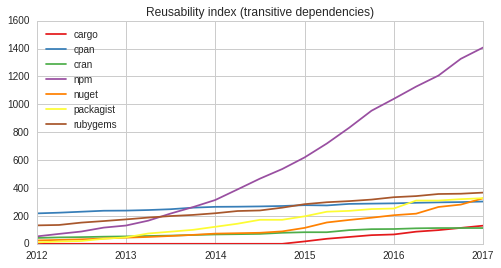

In [49]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['tr-in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (transitive dependencies)',
)

savefig(figure, 'graph_reusability_index_transitive')

In [50]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.764626,0.979983,0.972488,0.955469,0.900771,0.990111,0.994155
lin-log,0.761108,0.968733,0.98418,0.972282,0.992539,0.874406,0.98023
log-lin,0.222046,0.60817,0.472437,0.39037,0.344065,0.491063,0.520552
log-log,0.268428,0.636804,0.562512,0.637222,0.553605,0.748866,0.607739


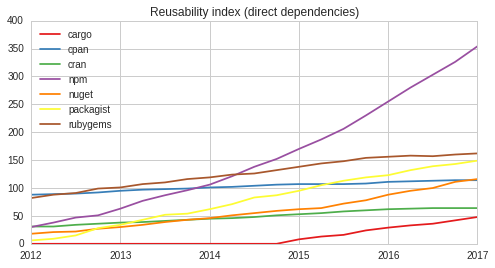

In [51]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (direct dependencies)',
)

savefig(figure, 'graph_reusability_index_direct')

In [52]:
evolution_linlog_regressions(df.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.770006,0.979418,0.988446,0.96471,0.972236,0.996695,0.98496
lin-log,0.761682,0.970412,0.977461,0.983034,0.9849,0.838301,0.967528
log-lin,0.224943,0.594448,0.532666,0.422435,0.449839,0.544251,0.581231
log-log,0.268497,0.6154,0.594167,0.642411,0.620691,0.799345,0.644659


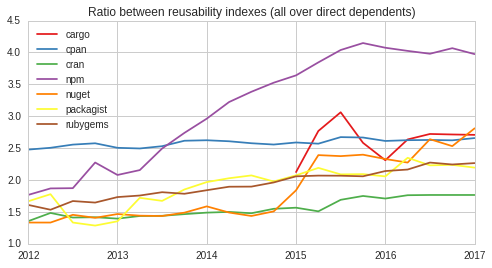

In [54]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        if graph.vcount() == 0:
            continue
        df.loc[date, ecosystem] = r_index(graph.vs['tr-in']) / r_index(graph.vs['in'])
    
df.plot(ax=ax, color=sub(COLORS, ECOSYSTEMS))

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio between reusability indexes (all over direct dependents)',
)

savefig(figure, 'graph_reusability_index_ratio')

## Reusability score

In [ ]:
# score = sum(1/d) for all n in "tr in", where d is the distance

# NOT MEMORY EFFICIENT!
# graph = graphs['cran'][DATE_RANGE[-1]]
# paths = graph.shortest_paths(mode=igraph.IN)

graph = graphs['cran'][DATE_RANGE[-1]]

for i, node in enumerate(graph.vs):
    score = sum(1/d for d in graph.shortest_paths(source=node.index, mode=igraph.IN)[0] if d > 0)
    node['r-score'] = score

for node in graph.vs:
    if node['r-score'] > 250:
        print('{}: {}'.format(node['name'], node['r-score']))